Подключение библиотек

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, Flatten, Activation, Input, Embedding, Dot, Add
from keras.models import Model
import warnings
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


Изучение датасета

In [28]:
file_path = r"D:\\BSU\\OOD\\lab4\\Reviews.csv"
df = pd.read_csv(file_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


In [29]:
print(df['Score'].min(), df['Score'].max())

1 5


Уменьшаем количество данных для уменьшения затраченных вычислительных мощностей

In [30]:
popular_products = df['ProductId'].value_counts()
df = df[df['ProductId'].isin(popular_products[popular_products >= 10].index)]

active_users = df['UserId'].value_counts()
df = df[df['UserId'].isin(active_users[active_users >= 3].index)]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 256287 entries, 13 to 568403
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      256287 non-null  int64 
 1   ProductId               256287 non-null  object
 2   UserId                  256287 non-null  object
 3   ProfileName             256272 non-null  object
 4   HelpfulnessNumerator    256287 non-null  int64 
 5   HelpfulnessDenominator  256287 non-null  int64 
 6   Score                   256287 non-null  int64 
 7   Time                    256287 non-null  int64 
 8   Summary                 256262 non-null  object
 9   Text                    256287 non-null  object
dtypes: int64(5), object(5)
memory usage: 21.5+ MB
None


Создание матрицы обратной связи, отражающей заинтересованность пользователей в различных продуктах

In [31]:
util_df = pd.pivot_table(data=df, values='Score', index='UserId', columns='ProductId')
util_df = util_df.fillna(0)

In [32]:
users = df['UserId'].unique()
products = df['ProductId'].unique()

userid2idx = {o: i for i, o in enumerate(users)}
productid2idx = {o: i for i, o in enumerate(products)}

df['userId'] = df['UserId'].apply(lambda x: userid2idx[x])
df['productId'] = df['ProductId'].apply(lambda x: productid2idx[x])

In [33]:
X = df[['userId', 'productId']]
y = df['Score']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=True, random_state=42)

Строятся две параллельные нейронные сети, результаты работы которых будут представлять полученные «вложения» пользователя и отдельного элемента данных, после чего для их агрегации используется скалярное произведение. 

In [49]:
n_latent_factors = 64
n_users = df['userId'].nunique()
n_product = df['productId'].nunique()

user_input = Input(shape=(1,), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

product_input = Input(shape=(1,), name='product_input', dtype='int64')
product_embedding = Embedding(n_product, n_latent_factors, name='product_embedding')(product_input)
product_vec = Flatten(name='FlattenMovies')(product_embedding)

user_bias = Embedding(n_users, 1, name='user_bias')(user_input)
user_bias = Flatten()(user_bias)

product_bias = Embedding(n_product, 1, name='product_bias')(product_input)
product_bias = Flatten()(product_bias)

dot_product = Dot(axes=1)([user_vec, product_vec])
pred = Add()([dot_product, user_bias, product_bias])

model = Model([user_input, product_input], pred)
model.compile(loss='mse', optimizer='adam')

In [50]:
history = model.fit(
    [X_train['userId'], X_train['productId']],
    y_train,
    batch_size=128,
    epochs=8,
    validation_data=([X_val['userId'], X_val['productId']], y_val),
    verbose=1
)

Epoch 1/8
1202/1202 [==============================] - 27s 22ms/step - loss: 17.5216 - val_loss: 14.8599
Epoch 2/8
1202/1202 [==============================] - 28s 24ms/step - loss: 10.3177 - val_loss: 7.7502
Epoch 3/8
1202/1202 [==============================] - 30s 25ms/step - loss: 4.8179 - val_loss: 5.0979
Epoch 4/8
1202/1202 [==============================] - 31s 26ms/step - loss: 2.6676 - val_loss: 4.0073
Epoch 5/8
1202/1202 [==============================] - 29s 24ms/step - loss: 1.5320 - val_loss: 3.4513
Epoch 6/8
1202/1202 [==============================] - 29s 24ms/step - loss: 0.8474 - val_loss: 3.1463
Epoch 7/8
1202/1202 [==============================] - 29s 24ms/step - loss: 0.4428 - val_loss: 2.9830
Epoch 8/8
1202/1202 [==============================] - 29s 24ms/step - loss: 0.2276 - val_loss: 2.9046


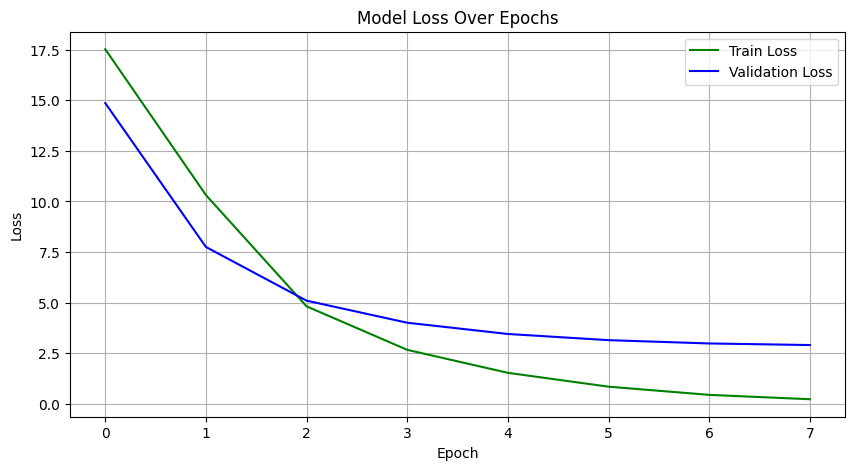

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'g', label='Train Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
model.save('recommender_model4.keras')

In [53]:
from keras.models import load_model
model = load_model('recommender_model4.keras')


In [54]:
y_pred = model.predict([X_test['userId'], X_test['productId']])

1602/1602 [==============================] - 1s 834us/step


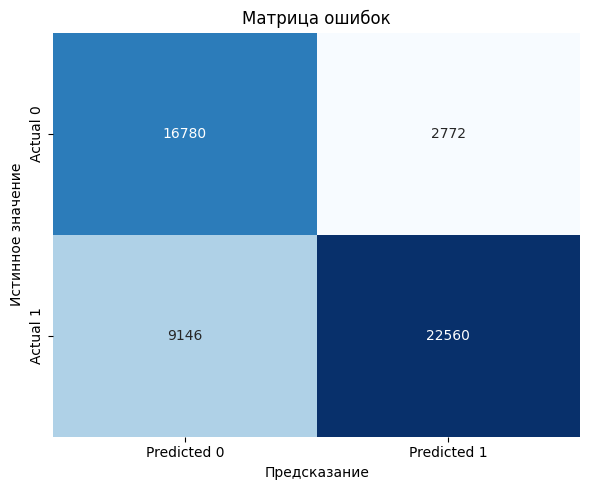

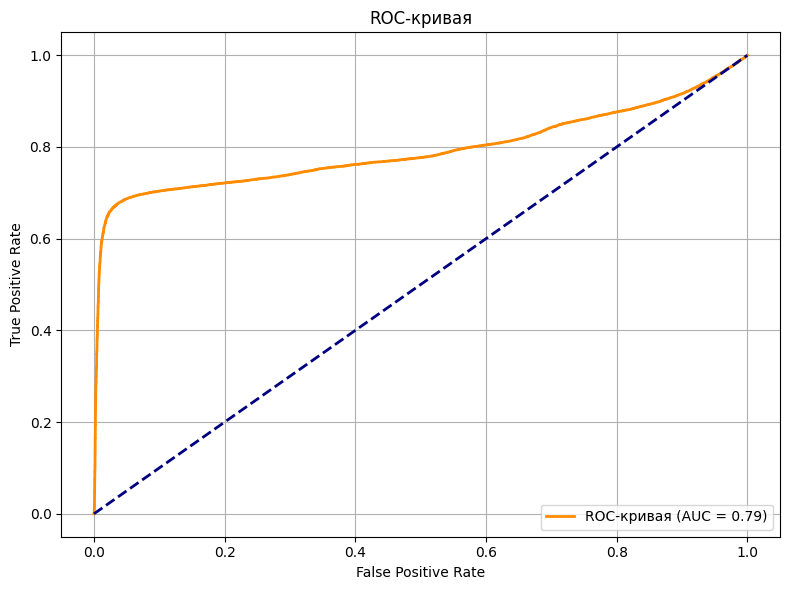

F1-score: 0.7911


In [55]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
import seaborn as sns

threshold = 4.0
y_true_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred.flatten() >= threshold).astype(int)

cm = confusion_matrix(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred.flatten())
roc_auc = roc_auc_score(y_true_binary, y_pred.flatten())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Предсказание")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"F1-score: {f1:.4f}")


В предыдущем случае вся обработка заключалась в получении новых представлений и объединении их на основе операции скалярного произведения, однако, этот процесс можно сделать менее тривиальным и использовать в качестве выходной метрики значение, подобранное на основе нейросетевого анализа. 

In [41]:
n_latent_factors = 64
n_users = df['userId'].nunique()
n_product = df['productId'].nunique()

user_input = Input(shape=(1,), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

product_input = Input(shape=(1,), name='product_input', dtype='int64')
product_embedding = Embedding(n_product, n_latent_factors, name='product_embedding')(product_input)
product_vec = Flatten(name='FlattenProducts')(product_embedding)

sim = Dot(axes=1)([user_vec, product_vec])

nn_inp = Dense(96, activation='relu')(sim)
nn_inp = Dropout(0.4)(nn_inp)
nn_inp = Dense(1, activation='relu')(nn_inp)

model2 = Model([user_input, product_input], nn_inp)
model2.compile(loss='mse', optimizer='adam')


In [43]:
history2 = model2.fit(
    [X_train['userId'], X_train['productId']],
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=([X_val['userId'], X_val['productId']], y_val),
    verbose=1
)

Epoch 1/10
1202/1202 [==============================] - 30s 25ms/step - loss: 0.3676 - val_loss: 0.6235
Epoch 2/10
1202/1202 [==============================] - 30s 25ms/step - loss: 0.2989 - val_loss: 0.5964
Epoch 3/10
1202/1202 [==============================] - 30s 25ms/step - loss: 0.2511 - val_loss: 0.5694
Epoch 4/10
1202/1202 [==============================] - 32s 27ms/step - loss: 0.1980 - val_loss: 0.5514
Epoch 5/10
1202/1202 [==============================] - 29s 24ms/step - loss: 0.1562 - val_loss: 0.5415
Epoch 6/10
1202/1202 [==============================] - 29s 24ms/step - loss: 0.1317 - val_loss: 0.5352
Epoch 7/10
1202/1202 [==============================] - 29s 24ms/step - loss: 0.1174 - val_loss: 0.5261
Epoch 8/10
1202/1202 [==============================] - 29s 24ms/step - loss: 0.1088 - val_loss: 0.5252
Epoch 9/10
1202/1202 [==============================] - 29s 24ms/step - loss: 0.1026 - val_loss: 0.5226
Epoch 10/10
1202/1202 [==============================] - 29s 24m

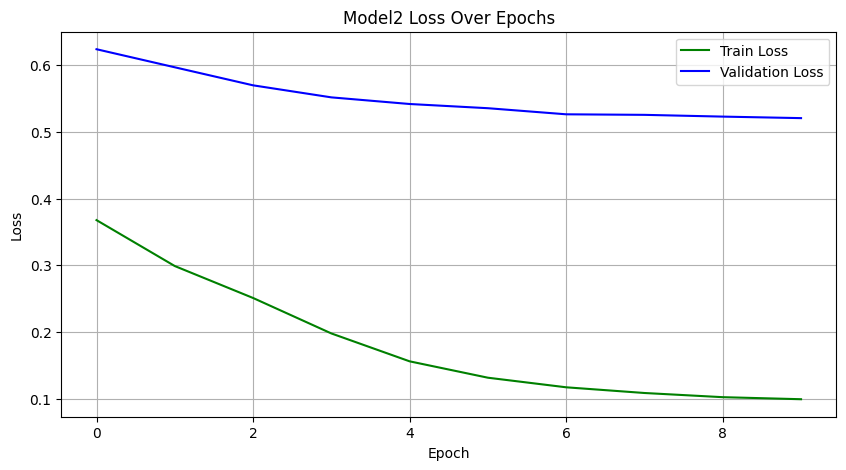

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], 'g', label='Train Loss')
plt.plot(history2.history['val_loss'], 'b', label='Validation Loss')
plt.title('Model2 Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
model2.save('recommender_model2331.keras')

In [46]:
model2 = load_model('recommender_model2331.keras')

In [47]:
y_pred2 = model2.predict([X_test['userId'], X_test['productId']])

1602/1602 [==============================] - 2s 1ms/step


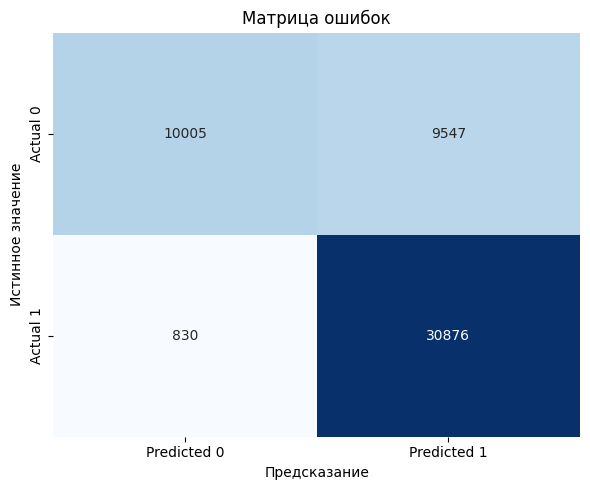

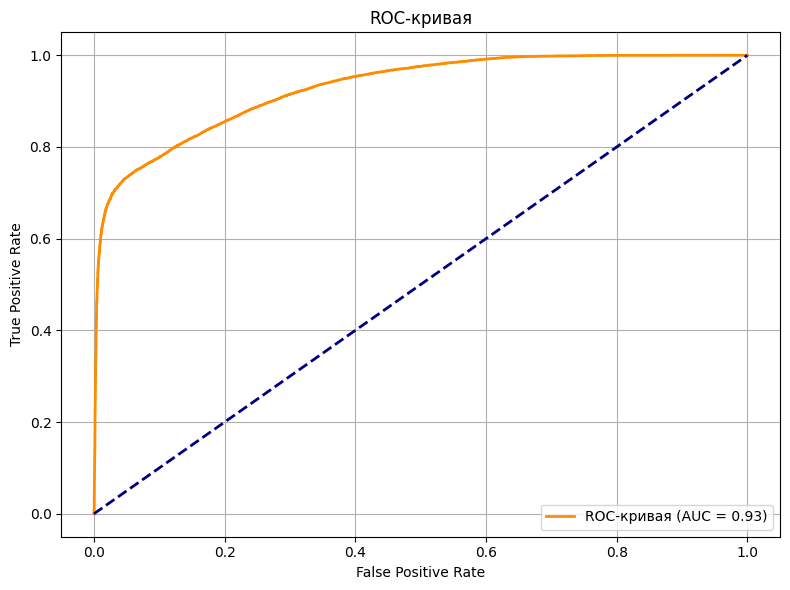

F1-score: 0.8561


In [48]:
threshold = 4.0
y_true_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred2.flatten() >= threshold).astype(int)

cm = confusion_matrix(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred2.flatten())
roc_auc = roc_auc_score(y_true_binary, y_pred2.flatten())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Предсказание")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"F1-score: {f1:.4f}")